In [4]:
import numpy as np
import matplotlib.pyplot as plt
import importlib.util
import sys
import os
from matplotlib.ticker import FuncFormatter
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib.collections import PathCollection

from matplotlib.patches import Rectangle
from matplotlib.patches import ConnectionPatch

from scipy.optimize import curve_fit

module_name = "utils_v2"
file_path = "/workspaces/TP3/utils_v2.py"

spec = importlib.util.spec_from_file_location(module_name, file_path)
module = importlib.util.module_from_spec(spec)
sys.modules[module_name] = module
spec.loader.exec_module(module)

# Importer le module
import utils_v2 as u

import pandas as pd

In [5]:
#import datas

Gases = ['AIR', 'HE', 'AR', 'N']
Ns = [48, 66,61,48]

Vs=[[] for i in range(len(Gases))]
Ps=[[] for i in range(len(Gases))]
discharge_Vs = [[] for i in range(len(Gases))]

for i, (gas, N) in enumerate(zip(Gases, Ns)):
    for j in range(1, N + 1):
        # Load pressures from P.xlsx
        pressures_df = pd.read_excel(f'/workspaces/TP3/TP_Plasma/Datas/P_{gas}.xlsx', usecols=[1], header=None)

        # Get the corresponding pressure for the current file
        pressure_value = pressures_df.iloc[j - 1, 0]

        if isinstance(pressure_value, str) and pressure_value.lower() == "rien":
            continue
        else:
            if j < 10:
                data = pd.read_csv(f'/workspaces/TP3/TP_Plasma/Datas/{gas}/{gas}000{j}.CSV', sep=';', decimal='.', header=21, usecols=[0, 1])
            else:
                data = pd.read_csv(f'/workspaces/TP3/TP_Plasma/Datas/{gas}/{gas}00{j}.CSV', sep=';', decimal='.', header=21, usecols=[0, 1])
            
            data_V = data.iloc[:, 0].to_numpy()

            # Convert into volts
            data_V = data_V * 1000

            Vs[i].append(data_V)
        
            # Convert pressure_value to a float
            pressure_value = float(pressure_value)
            Ps[i].append(pressure_value)

            discharge_Vs[i].append(np.max(data_V))
            


dt = 0.401






In [4]:
# #plot
# xlabel = "Time (s)"
# ylabel = "Voltage (V)"

# for g in range(len(Gases)):
#     #plot for air
#     ax,fig = u.create_figure_and_apply_format((8,6),xlabel=xlabel, ylabel=ylabel)

#     for i in range(len(Vs[g])):
#         V = np.array(Vs[g][i])
#         t = np.linspace(0, (len(V) - 1) * dt, len(V))

#         # ax.plot(t,V, label=f'P = {Ps[i-1]} mbar')
#         ax.plot(t,V)
        
#         ax.set_xlim(0, 30)


#     u.set_legend_properties(ax)
#     plt.show()




## Plot the Paschen curve

### Error and fit functions

In [6]:
#in cm, 1cm of error
d = 41.2
d_error = 1

Ps_error = [[] for i in range(len(Gases))]
Ps_torr = [[] for i in range(len(Gases))]
Ps_error_torr = [[] for i in range(len(Gases))]
pd_error = [[] for i in range(len(Gases))]
for g in range(len(Gases)):
    # Build the error on the pressure
    Ps_error[g] = np.array([0.1 * 10 ** (np.floor(np.log10(p)) - 1) for p in Ps[g]])

    Ps_error_torr[g] = Ps_error[g] * 0.75006

    # Convert pressure to Torr
    Ps_torr[g] = np.array(Ps[g]) * 0.75006

    # Calculate the error on pd
    pd_error[g] = Ps_torr[g] * d_error + Ps_error_torr[g] * d



#define the function for the fit ¨
def fit(pd, A, B, gamma):
    return B * pd / (np.log(A * pd) - np.log(np.log(1 + 1/gamma))) 


# Define the transformed fit function in log-space
def log_fit(log_pd, log_A, log_B, gamma):
    pd = np.exp(log_pd)  # Convert back from log-space
    A = np.exp(log_A)
    B = np.exp(log_B)
    return np.log(B * pd / (np.log(A * pd) - np.log(np.log(1 + 1/gamma))))


#define a fit with offset
def fit_offset(pd, A, B, C, D,E):
    return E + (B * (pd-D)) / (np.log(A * (pd-D)) - C)


def C_to_gamma(C):
    return 1/(np.exp(np.exp(C))-1)

def gamma_to_C(gamma):
    return np.log(np.log(1+1/gamma))



### All gases on the same plot

[ 0.95797663  0.95797663  1.01978158  1.08158652  1.14339146  1.17429394
  1.26700135  1.23609888  1.35970877  1.42151371  1.5451236   1.63783102
  1.69963596  1.79234338  1.88505079  1.97775821  2.13227057  2.25588046
  2.37949034  2.47219776  2.62671012  2.78122248  2.93573484  3.0902472
  4.6353708   6.1804944   7.725618    9.2707416  10.8158652  12.3609888
 13.9061124  15.451236   16.9963596  18.5414832  20.39563152 21.6317304
 23.176854   24.7219776  26.2671012  27.8122248 ]
[np.float64(3971.545), np.float64(3772.4519999999998), np.float64(2984.989), np.float64(2289.273), np.float64(1843.985), np.float64(2033.738), np.float64(1639.277), np.float64(1644.29), np.float64(1478.549), np.float64(1445.076), np.float64(1338.592), np.float64(1304.1560000000002), np.float64(1254.322), np.float64(1204.498), np.float64(1168.896), np.float64(1136.76), np.float64(1137.7440000000001), np.float64(1146.502), np.float64(1120.289), np.float64(1036.134), np.float64(1051.821), np.float64(1082.31499999

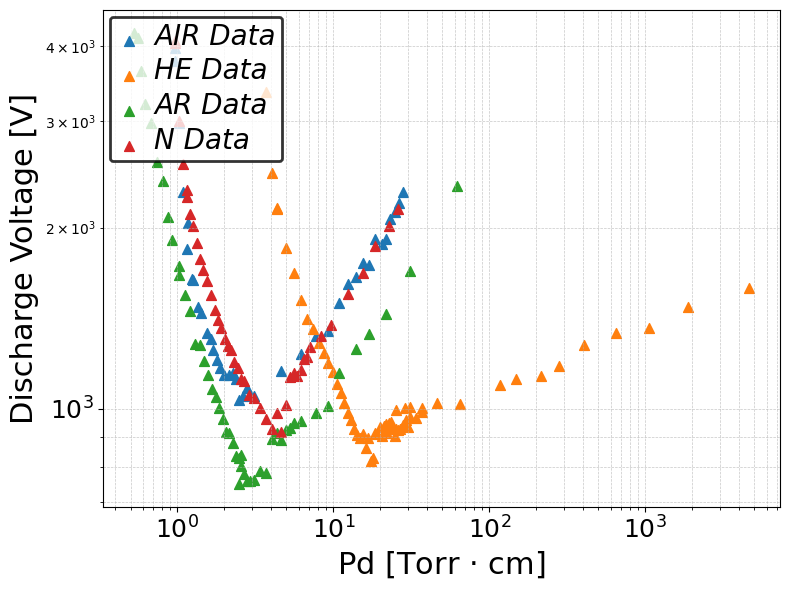

In [6]:


# Plot all gases in the same plot
ax, fig = u.create_figure_and_apply_format((8, 6), xlabel=r"Pd [Torr $\cdot$ cm]", ylabel="Discharge Voltage [V]")

for g in range(len(Gases)):
    # Scatter plot for each gas
    pd = Ps_torr[g] * d
    discharge_V = discharge_Vs[g]
    
    print(pd)
    print(discharge_V)
    
    ax.scatter(pd, discharge_V, label=f'{Gases[g]} Data', marker='^', s=50)
    # ax.plot(pd, discharge_V, label=f'{Gases[g]} Data', linestyle='--')
    # ax.errorbar(pd, discharge_V, xerr=pd_error[g], yerr=0.1, fmt='^', ecolor='red', capsize=5, alpha=0.4)

    
ax.set_xscale('log')
ax.set_yscale('log')

u.set_legend_properties(ax, loc="upper left")
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
plt.show()



    


### Separate plots for each gas

In [7]:

# # Separate plots for each gas
# for g in range(len(Gases)):
#     ax, fig = u.create_figure_and_apply_format((8, 6), xlabel=r"Pd [Torr $\cdot$ cm]", ylabel="Discharge Voltage [V]")

#     # Scatter plot for the current gas
#     ax.errorbar(Ps_torr[g] * d, discharge_Vs[g], xerr=pd_error[g], yerr=0.1, fmt='^', ecolor='red', capsize=5, alpha=0.4)
#     ax.scatter(Ps_torr[g] * d, discharge_Vs[g], label=f'{Gases[g]} Data', marker='^', s=50)
    
    
#     if g == 0 :
#         p0 = [0.57, 247, 0.095]
#     elif g == 1 :
#         p0 = [0.04, 13, 0.263]
#     elif g == 2 :
#         p0 = [0.2, 97, 0.095]
    
#     popt, pcov = curve_fit(fit, Ps_torr[g] * d, discharge_Vs[g], p0=p0, bounds=([0,0,0], [np.inf, np.inf, 1]), maxfev=10000)
#     pd_fit = np.linspace(np.min( Ps_torr[g] * d), np.max( Ps_torr[g] * d), 100000)
#     ax.plot(pd_fit, fit(pd_fit, *popt), label=f'{Gases[g]} Fit: A={popt[0]:.2f}, B={popt[1]:.2f}, γ={popt[2]:.2f}')

#     ax.set_xscale('log')
#     ax.set_yscale('log')
#     u.set_legend_properties(ax, loc="upper left")
#     plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
#     plt.show()


### Using log fitting method

In [8]:

# for g in range(len(Gases)):
#     # Log-transform your x and y data before fitting
#     log_pd_data = np.log(Ps_torr[g] * d)
#     log_V_data = np.log(discharge_Vs[g])

#     # Fit in log-log space
#     popt, pcov = curve_fit(log_fit, log_pd_data, log_V_data, p0=[np.log(10), np.log(247), 1], 
#                         bounds=([-np.inf, -np.inf, 0], [np.inf, np.inf, np.inf]), maxfev=10000)

#     # Generate fitted curve in log-space
#     pd_fit = np.log(np.linspace(0.95, 100, 100000))
#     log_V_fit = log_fit(pd_fit, *popt)

#     # Plot in log-log scale
#     fig, ax = plt.subplots(figsize=(8, 6))
#     ax.scatter(np.exp(log_pd_data), np.exp(log_V_data), label="Data", marker="^", s=50, color = 'blue')
#     ax.plot(np.exp(pd_fit), np.exp(log_V_fit), label=f"Fit: A={np.exp(popt[0]):.2f}, B={np.exp(popt[1]):.2f}, γ={popt[2]:.2f}", color = 'red', linestyle='--')

#     ax.set_xscale("log")
#     ax.set_yscale("log")
#     plt.legend()
#     plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
#     plt.show()





### Using offset fitting method

In [7]:
params = np.zeros((len(Gases), 5))

# Separate plots for each gas
for g in range(len(Gases)):
    #define parameters for the fit
    gas = Gases[g]
    
    pd = Ps_torr[g] * d
    V = discharge_Vs[g]

    
    if gas =='AIR':
        p0 = [3.24,244,1.51,-6.84e-1,142]
        bounds = ([-np.inf, -np.inf, -np.inf, -np.inf, -np.inf], [np.inf, np.inf, np.inf, np.inf, np.inf])
    if gas == 'HE':

        p0 =[4,100,1.51,-6.84e-1,-142]
        bounds = ([-np.inf, -np.inf, 0, -np.inf, -np.inf], [np.inf, np.inf, 2.3, np.inf, np.inf])
    
    if gas == 'AR':

        p0 = [1.69,100,0.9,-10,-1000]
        bounds = ([-np.inf, -np.inf, 0, -np.inf, -np.inf], [np.inf, np.inf, 4, np.inf, np.inf])
        
    if gas == 'N':
        p0 = [1.69,100,0.9,-10,142]
        bounds = ([-np.inf, -np.inf, 0, -np.inf, -np.inf], [np.inf, np.inf, 4, np.inf, np.inf])
        
    p0 = [3.24,244,1.51,-5,0]
    #fit
    popt, pcov = curve_fit(fit_offset, pd, V, p0=p0 , maxfev=100000, bounds=bounds)
    
    #add the parameters to the array
    params[g] = popt

#

/tmp/ipykernel_4930/3751996222.py:38: RuntimeWarning: invalid value encountered in log
  return E + (B * (pd-D)) / (np.log(A * (pd-D)) - C)


### Plot the offset fitting method - all gases

Gas :  AIR
gamma :  0.060848082529921944
Gas :  HE
gamma :  0.00026387584660212684
Gas :  AR
gamma :  0.037261492644515795
Gas :  N
gamma :  0.03857127951227375


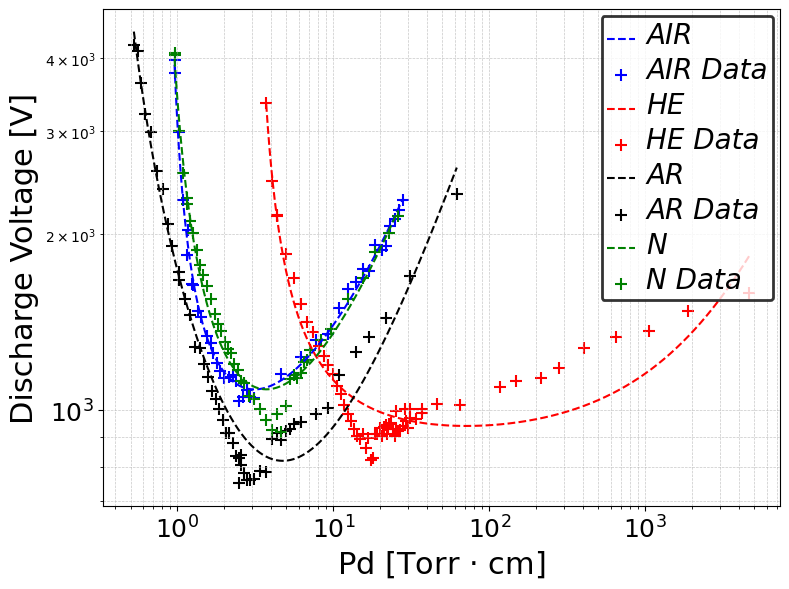

In [8]:
ax, fig =u.create_figure_and_apply_format((8, 6), xlabel=r"Pd [Torr $\cdot$ cm]", ylabel="Discharge Voltage [V]")

colors = ['blue', 'red', 'black', 'green']

for g in range(len(Gases)):
    pd = Ps_torr[g] * d
    V = discharge_Vs[g]
    
    popt = params[g]
    C = popt[2]
    
    pd_fit = np.linspace(np.min(pd), np.max(pd), 100000)
    ax.plot(pd_fit, fit_offset(pd_fit, *popt), label=f'{Gases[g]}', linestyle='--', color=colors[g])
    print("Gas : ", Gases[g])
    print("gamma : ", 1/(np.exp(np.exp(C)-1)))


    # Scatter plot for the current gas
    # ax.errorbar(pd, V, xerr=pd_error[g], yerr=0.1, fmt='^', ecolor='red', capsize=5, alpha=0.4)
    ax.scatter(pd, V, label=f'{Gases[g]} Data', marker='+', s=75, color=colors[g])
    

    ax.set_xscale('log')
    ax.set_yscale('log')
    u.set_legend_properties(ax, loc="upper right")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)


### Plot the offset fitting method - separate gases

Gas :  AIR
gamma :  0.060848082529921944


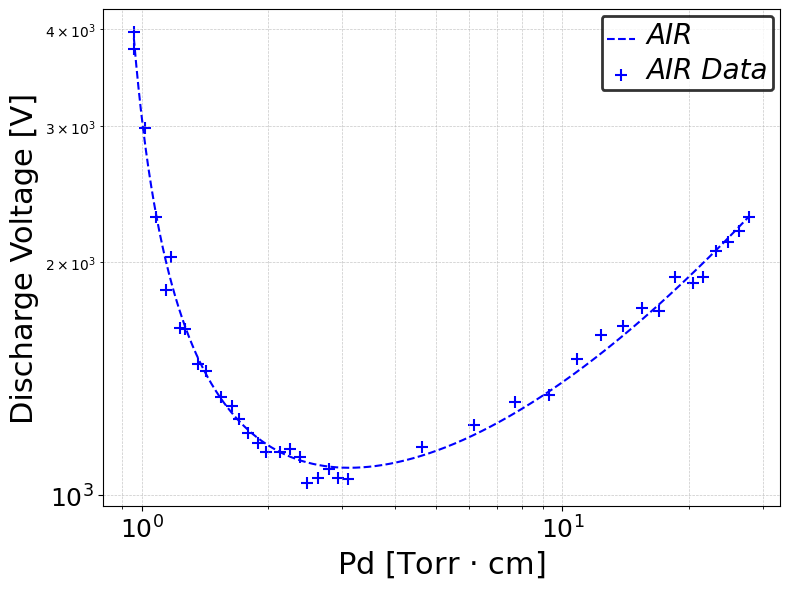

Gas :  HE
gamma :  0.00026387584660212684


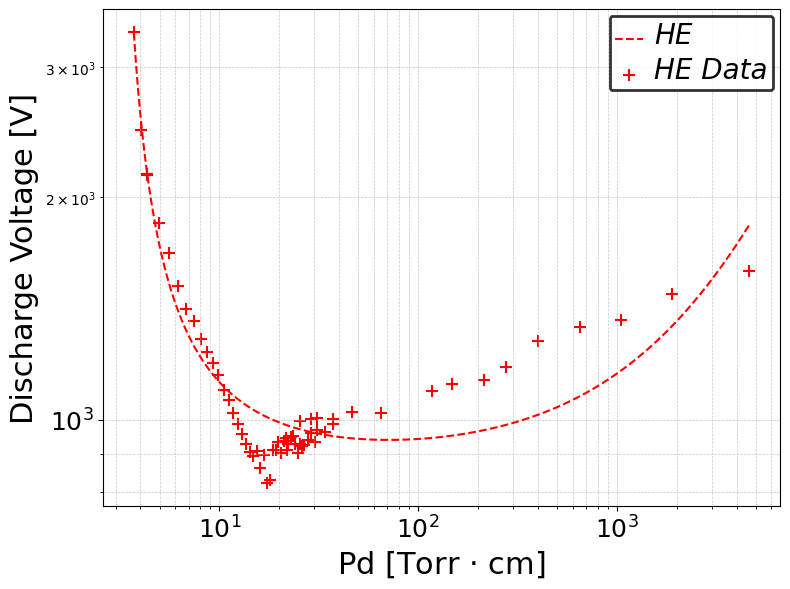

Gas :  AR
gamma :  0.037261492644515795


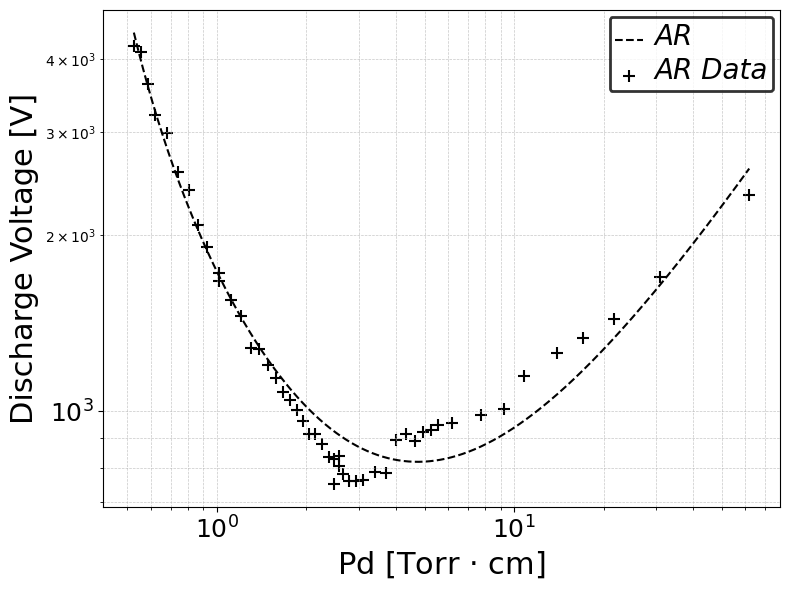

Gas :  N
gamma :  0.03857127951227375


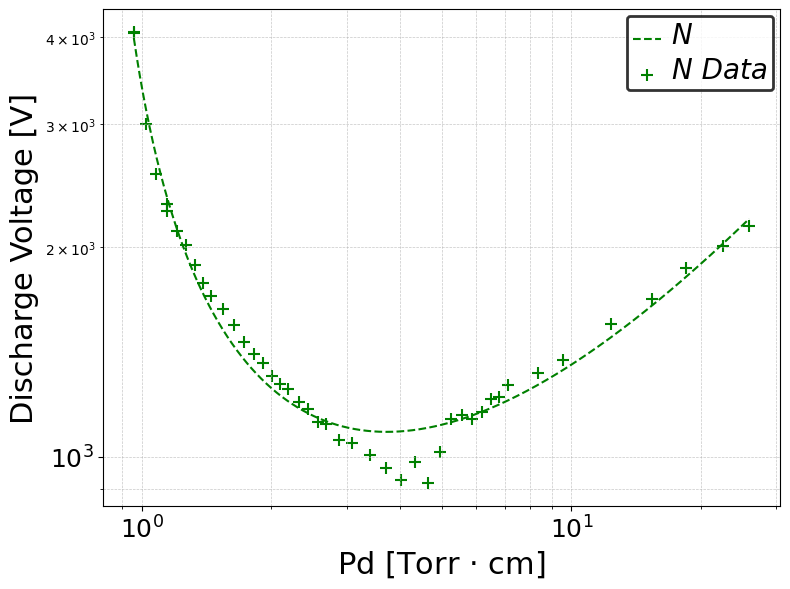

In [9]:

colors = ['blue', 'red', 'black', 'green']

for g in range(len(Gases)):
    ax, fig =u.create_figure_and_apply_format((8, 6), xlabel=r"Pd [Torr $\cdot$ cm]", ylabel="Discharge Voltage [V]")

    pd = Ps_torr[g] * d
    V = discharge_Vs[g]
    
    popt = params[g]
    C = popt[2]
    
    pd_fit = np.linspace(np.min(pd), np.max(pd), 100000)
    ax.plot(pd_fit, fit_offset(pd_fit, *popt), label=f'{Gases[g]}', linestyle='--', color=colors[g])
    print("Gas : ", Gases[g])
    print("gamma : ", 1/(np.exp(np.exp(C)-1)))


    # Scatter plot for the current gas
    # ax.errorbar(pd, V, xerr=pd_error[g], yerr=0.1, fmt='^', ecolor='red', capsize=5, alpha=0.4)
    ax.scatter(pd, V, label=f'{Gases[g]} Data', marker='+', s=75, color=colors[g])
    

    ax.set_xscale('log')
    ax.set_yscale('log')
    u.set_legend_properties(ax, loc="upper right")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
    
    plt.show()


### Fitting using differential evolution

In [ ]:
from scipy.optimize import differential_evolution
import numpy as np
import matplotlib.pyplot as plt

# Define reasonable bounds for parameters (modify as needed)
finite_bounds = {
    'AIR': [(0, 50), (0, 400), (gamma_to_C(1),gamma_to_C(0.0001)), (-10, 10), (0, 500)],
    'HE':  [(0, 50), (0, 400), (gamma_to_C(1), gamma_to_C(0.0001)), (-10, 10), (0, 500)],
    'AR':  [(0, 50), (0, 400), (gamma_to_C(1), gamma_to_C(0.0001)), (-10, 10), (0, 500)],
    'N':   [(0, 50), (0, 400), (gamma_to_C(1), gamma_to_C(0.0001)), (-10, 10), (0, 500)]
}

# Separate plots for each gas
for g in range(len(Gases)):
    ax, fig = u.create_figure_and_apply_format((8, 6), xlabel=r"Pd [Torr $\cdot$ cm]", ylabel="Discharge Voltage [V]")

    # Define parameters for the fit
    gas = Gases[g]
    pd = Ps_torr[g] * d
    V = discharge_Vs[g]

    # Limit data for 'HE' as in original code
    if gas == 'HE':
        pd = pd[:46]
        V = V[:46]


    
    # Define error function (sum of squared errors)
    def error_function(params, pd, V):
        return np.sum((V - fit_offset(pd, *params))**2)  # Minimize squared error

    # Get finite bounds for the current gas
    bounds = finite_bounds[gas]

    # Fit using differential evolution
    result = differential_evolution(error_function, args=(pd, V),bounds = bounds, popsize=30, maxiter=5000, mutation=(0.8, 1.2), recombination=0.85, workers=-1,tol = 1e-6)
    popt = result.x  # Extract optimized parameters

    # Generate fit curve
    pd_fit = np.linspace(np.min(pd), np.max(pd), 100000)
    A, B, C, D, E = popt  # Extract best-fit values

    # Plot the fit
    ax.plot(pd_fit, fit_offset(pd_fit, *popt),
            label=f'{Gases[g]} Fit: A={A:.2e}, B={B:.2e}, \n C={C:.2e}, D={D:.2e}, E={E:.2e}', 
            color='red', linestyle='--')

    print("Gas : ", Gases[g])
    print("gamma : ", 1/(np.exp(np.exp(C)-1)))

    # Scatter plot for the current gas
    ax.scatter(pd, V, label=f'{Gases[g]} Data', marker='^', s=50, color='blue')

    # Set log scale and legend
    ax.set_xscale('log')
    ax.set_yscale('log')
    u.set_legend_properties(ax, loc="upper left")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)


/home/codespace/.local/lib/python3.12/site-packages/scipy/optimize/_differentialevolution.py:488: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,
/tmp/ipykernel_82284/3751996222.py:38: RuntimeWarning: invalid value encountered in log
  return E + (B * (pd-D)) / (np.log(A * (pd-D)) - C)
/tmp/ipykernel_82284/3751996222.py:38: RuntimeWarning: invalid value encountered in log
  return E + (B * (pd-D)) / (np.log(A * (pd-D)) - C)
/tmp/ipykernel_82284/3751996222.py:38: RuntimeWarning: invalid value encountered in log
  return E + (B * (pd-D)) / (np.log(A * (pd-D)) - C)
/tmp/ipykernel_82284/3751996222.py:38: RuntimeWarning: invalid value encountered in log
  return E + (B * (pd-D)) / (np.log(A * (pd-D)) - C)
Process ForkPoolWorker-4:
Process ForkPoolWorker-3:
Process ForkPoolWorker-2:
Process ForkPoolWorker-1:
Traceback (most recent call last):
Traceback (most recen